<a href="https://colab.research.google.com/github/Iman-Kalyan-Majumder/FYP/blob/main/HM_Alternative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [49]:
data = pd.read_csv('BridgeMetrics.csv').drop('Unnamed: 0', axis=1)
data.head()

,Max,Min,Mean,Median,Std,PeakToPeak,Mode,Healthy
0,0.168,-0.192,-0.016880,-0.024,0.063430,0.360,-0.040,0
1,0.168,-0.192,-0.016880,-0.024,0.063430,0.360,-0.040,0
2,0.144,-0.176,0.001216,0.008,0.061272,0.320,0.032,1
3,0.128,-0.208,-0.019584,-0.016,0.063845,0.336,-0.024,1
4,0.128,-0.176,-0.015600,-0.016,0.061276,0.304,-0.024,1


In [50]:
X, y = data.drop('Healthy', axis=1), data['Healthy']

In [51]:
X_train, X_temp, y_train, y_temp = train_test_split(X[list(feature_subset)],y, test_size=0.3, shuffle=True, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

##Feature Selection

In [52]:
class FeatureSelection:
    def __init__(self, data, clabel, oversample) -> None:
        X, y = data.drop(clabel, axis=1), data[clabel]
        self.clabel = clabel
        features = {_ for _ in data.columns}
        features.remove(clabel)
        self.features = features

        if oversample:
            over = RandomOverSampler()
            X, y = over.fit_resample(X,y)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=42)

    def wrapper(self, feature_subset):
        model = RandomForestClassifier(max_depth=16)
        model.fit(self.X_train[list(feature_subset)],self.y_train)
        y_pred=model.predict(self.X_test[list(feature_subset)])
        return accuracy_score(self.y_test,y_pred)

    def sfs(self, count, keep=set()):
        feature_subset = keep.copy()
        feature_set = self.features.copy() - keep

        if len(feature_set)==0:
            return (feature_subset, self.wrapper(feature_subset))

        accuracy = 0
        for _ in range(0,count):
            best_attribute = ""
            best_report = 0
            for attribute in feature_set:
                feature_subset.add(attribute)
                report = self.wrapper(feature_subset)*100
                if report > best_report:
                    best_attribute=attribute
                    best_report=report
                feature_subset.remove(attribute)

            accuracy = best_report
            feature_subset.add(best_attribute)
            feature_set.remove(best_attribute)

        return (feature_subset, accuracy)

    def sbr(self, count, fromset=set()):
        if len(fromset)==1:
            return (set(), 0)

        feature_set = self.features.copy() if len(fromset)==0 else fromset
        feature_subset = feature_set.copy()
        for _ in range(0,len(feature_set)-count):
            worst_attribute = ""
            best_report = 0
            for attribute in feature_subset:
                feature_subset.remove(attribute)
                report = self.wrapper(feature_subset)*100
                if report > best_report:
                    worst_attribute=attribute
                    best_report=report
                feature_subset.add(attribute)

            feature_subset.remove(worst_attribute)

        accuracy = self.wrapper(feature_subset)*100
        return (feature_subset, accuracy)

    def lrs(self, count, l, r):
        feature_set = self.features.copy()
        if l>r:
            feature_subset=set()
            while len(feature_subset)<count:
                feature_subset = self.sfs(l, keep=feature_subset)[0]
                feature_subset = self.sbr(len(feature_subset)-r, fromset=feature_subset)[0]
                feature_set=feature_set-feature_subset

            accuracy = self.wrapper(feature_subset)*100
            return (feature_subset, accuracy)
        else:
            feature_subset=feature_set.copy()
            while len(feature_subset)>count:
                temp_subset = self.sbr(len(feature_subset)-r)[0]
                feature_set = feature_set | (feature_subset-temp_subset)
                feature_subset = temp_subset
                temp_subset = self.sfs(l, feature_subset)[0]
                feature_set = feature_set - (temp_subset-feature_subset)
                feature_subset = temp_subset

            accuracy = self.wrapper(feature_subset)*100
            return (feature_subset, accuracy)

    def sffs(self, count):
        feature_subset = set()
        while len(feature_subset)<count:
            feature_subset, accuracy = self.sfs(1, keep=feature_subset)
            prev_acc = 0
            while accuracy > prev_acc:
                prev_acc = accuracy
                temp_subset, temp_acc = self.sbr(len(feature_subset)-1, fromset=feature_subset)
                if temp_acc>accuracy:
                    accuracy = temp_acc
                    feature_subset = temp_subset

        return (feature_subset, self.wrapper(feature_subset)*100)

    def sfbr(self, count):
        feature_subset = self.features.copy()
        while len(feature_subset)>count:
            feature_subset, accuracy = self.sbr(len(feature_subset)-1, fromset=feature_subset)
            prev_acc = 0
            while accuracy > prev_acc:
                prev_acc = accuracy
                temp_subset, temp_acc = self.sfs(1, keep=feature_subset)
                if temp_acc>accuracy:
                    accuracy = temp_acc
                    feature_subset = temp_subset

        return (feature_subset, self.wrapper(feature_subset)*100)


##Random Forest Classifier

In [53]:
fs = FeatureSelection(data, "Healthy", True)
feature_subset = fs.sffs(4)[0]
model = RandomForestClassifier(random_state=42)
X,y = data.drop('Healthy', axis=1)[list(feature_subset)], data['Healthy']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(feature_subset)

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       529
           1       1.00      0.47      0.64       555

    accuracy                           0.73      1084
   macro avg       0.82      0.74      0.71      1084
weighted avg       0.83      0.73      0.71      1084

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       131
           1       1.00      0.54      0.70       140

    accuracy                           0.76       271
   macro avg       0.84      0.77      0.75       271
weighted avg       0.84      0.76      0.75       271

{'Max', 'PeakToPeak', 'Mean', 'Std'}


###Training Accuracy = 73% and Test Accuracy = 76%
###The most important features are 'Max', 'PeakToPeak', 'Mean', and 'Std'

In [54]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Input(4),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [55]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [56]:
early_stopping =tf.keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.01,
    restore_best_weights=True
)

In [57]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
)

Epoch 1/200
34/34 [==============================] - 3s 13ms/step - loss: 0.7835 - accuracy: 0.5277 - val_loss: 0.6932 - val_accuracy: 0.5196
Epoch 2/200
34/34 [==============================] - 0s 5ms/step - loss: 0.7280 - accuracy: 0.5157 - val_loss: 0.6925 - val_accuracy: 0.5147
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 0.6562 - accuracy: 0.5849 - val_loss: 0.6914 - val_accuracy: 0.5049
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.5895 - val_loss: 0.6909 - val_accuracy: 0.4853
Epoch 5/200
34/34 [==============================] - 0s 5ms/step - loss: 0.5923 - accuracy: 0.6596 - val_loss: 0.6920 - val_accuracy: 0.4804
Epoch 6/200
34/34 [==============================] - 0s 5ms/step - loss: 0.5907 - accuracy: 0.6596 - val_loss: 0.6928 - val_accuracy: 0.4853
Epoch 7/200
34/34 [==============================] - 0s 5ms/step - loss: 0.6081 - accuracy: 0.6421 - val_loss: 0.6911 - val_accuracy: 0.4902
Epoch 8/200


In [58]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 5ms/step - loss: 0.4882 - accuracy: 0.7565


[0.4881783127784729, 0.7564575672149658]

In [59]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_train).round().astype(int)
print(classification_report(y_train, y_pred))

34/34 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       529
           1       1.00      0.47      0.64       555

    accuracy                           0.73      1084
   macro avg       0.82      0.73      0.71      1084
weighted avg       0.83      0.73      0.71      1084



###Training Accuracy = 73% and Test Accuracy = 75.64%

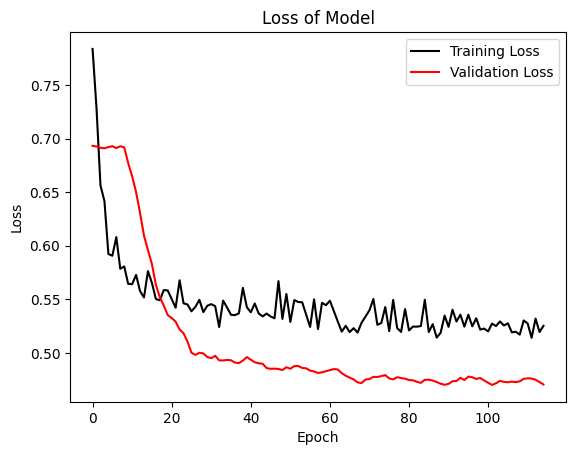

In [61]:
plt.plot(history.history['loss'], label='Training Loss', color='black')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Loss of Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()